In [ ]:
# Ensemble baseline model


In [45]:
import numpy
import pandas as pd
import sklearn
import scipy
import xgboost
import shap
import matplotlib as plt

print("NumPy version:", numpy.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("SciPy version:", scipy.__version__)
print("XGBoost version:", xgboost.__version__)
print("SHAP version:", shap.__version__)
print("Matplotlib version:", plt.__version__)


NumPy version: 1.26.4
Pandas version: 1.3.3
Scikit-learn version: 1.3.0
SciPy version: 1.10.0
XGBoost version: 1.6.2
SHAP version: 0.43.0
Matplotlib version: 3.7.2


In [46]:
# Load the data
data = pd.read_csv("baseline_model_data.csv")

# Define features (X) and target (y)
X = data.drop(columns=["participant_id", "general_psychopathology"])  # All predictors
y = data["general_psychopathology"]

print("Data loaded successfully.")
print(f"Dataset shape: {data.shape}")
print(f"Feature matrix shape: {X.shape}, Target vector shape: {y.shape}")

Data loaded successfully.
Dataset shape: (172, 17)
Feature matrix shape: (172, 15), Target vector shape: (172,)


In [47]:
# Nested Cross-Validation

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error
import shap
import numpy as np
import pandas as pd

# Define the MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Define hyperparameter grids
param_grid_xgb = {'max_depth': [3, 5, 10], 'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100]}
param_grid_rf = {'max_depth': [5, 10], 'n_estimators': [50, 100], 'min_samples_split': [2, 5]}

# Create bins for stratification
bins = pd.qcut(y, q=10, duplicates="drop").astype("category").cat.codes  # Convert to discrete class labels

# Outer loop: Perform stratified splitting based on bins
nested_scores = []
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in outer_cv.split(X, bins):
    # Split the data into training and testing sets for the current fold
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Create bins for the inner loop
    inner_bins = pd.qcut(y_train, q=10, duplicates="drop").cat.codes
    inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Grid search for XGBoost
    xgb_model = XGBRegressor(random_state=42)
    xgb_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid_xgb,
        scoring=mae_scorer,
        cv=inner_cv.split(X_train, inner_bins),
        n_jobs=-1,
        verbose=1
    )
    xgb_search.fit(X_train, y_train)

    # Grid search for Random Forest
    rf_model = RandomForestRegressor(random_state=42)
    rf_search = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid_rf,
        scoring=mae_scorer,
        cv=inner_cv.split(X_train, inner_bins),
        n_jobs=-1,
        verbose=1
    )
    rf_search.fit(X_train, y_train)

    # Define and fit the stacking regressor
    meta_model = LinearRegression()
    stacking_model = StackingRegressor(
        estimators=[('xgb', xgb_search.best_estimator_), ('rf', rf_search.best_estimator_)],
        final_estimator=meta_model,
        passthrough=True  # Meta-model uses both predictions and original features
    )
    stacking_model.fit(X_train, y_train)

    # Test predictions and metrics
    y_pred = stacking_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    nested_scores.append(test_mae)

    # Output the fold results
    print(f"Outer Fold Test MAE: {test_mae:.3f}")
    print(f"Best Params in Inner Loop for XGB: {xgb_search.best_params_}")
    print(f"Best Params in Inner Loop for RF: {rf_search.best_params_}")

# Calculate the mean and standard deviation of the nested CV scores
mean_nested_score = np.mean(nested_scores)
std_nested_score = np.std(nested_scores)

print(f"\nNested Cross-Validation Mean MAE: {mean_nested_score:.3f}")
print(f"Nested Cross-Validation Std MAE: {std_nested_score:.3f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Outer Fold Test MAE: 15.029
Best Params in Inner Loop for XGB: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Params in Inner Loop for RF: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Outer Fold Test MAE: 15.285
Best Params in Inner Loop for XGB: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Params in Inner Loop for RF: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Outer Fold Test MAE: 11.547
Best Params in Inner Loop for XGB: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
Best Params in Inner Loop for RF: {'max_depth': 5, 'min_samples_split': 5, 'n_est

In [48]:
# Feature Importance for Base Models (not SHAP)
print("\nFeature Importance for XGBoost:")
print(pd.Series(xgb_search.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False))

print("\nFeature Importance for Random Forest:")
print(pd.Series(rf_search.best_estimator_.feature_importances_, index=X.columns).sort_values(ascending=False))


Feature Importance for XGBoost:
Hammer_limbic network_AVG                           0.096731
Hammer_default mode network_AVG                     0.091346
Stroop_limbic network_AVG                           0.081233
Resting-State_limbic network_AVG                    0.080057
Stroop_salience network_AVG                         0.074586
Hammer_dorsal attention network_AVG                 0.067632
Hammer_salience network_AVG                         0.067405
Hammer_frontoparietal control network_AVG           0.066326
Stroop_frontoparietal control network_AVG           0.065383
Stroop_default mode network_AVG                     0.061178
Resting-State_dorsal attention network_AVG          0.059933
Resting-State_salience network_AVG                  0.053116
Stroop_dorsal attention network_AVG                 0.051334
Resting-State_frontoparietal control network_AVG    0.045863
Resting-State_default mode network_AVG              0.037877
dtype: float32

Feature Importance for Random Forest

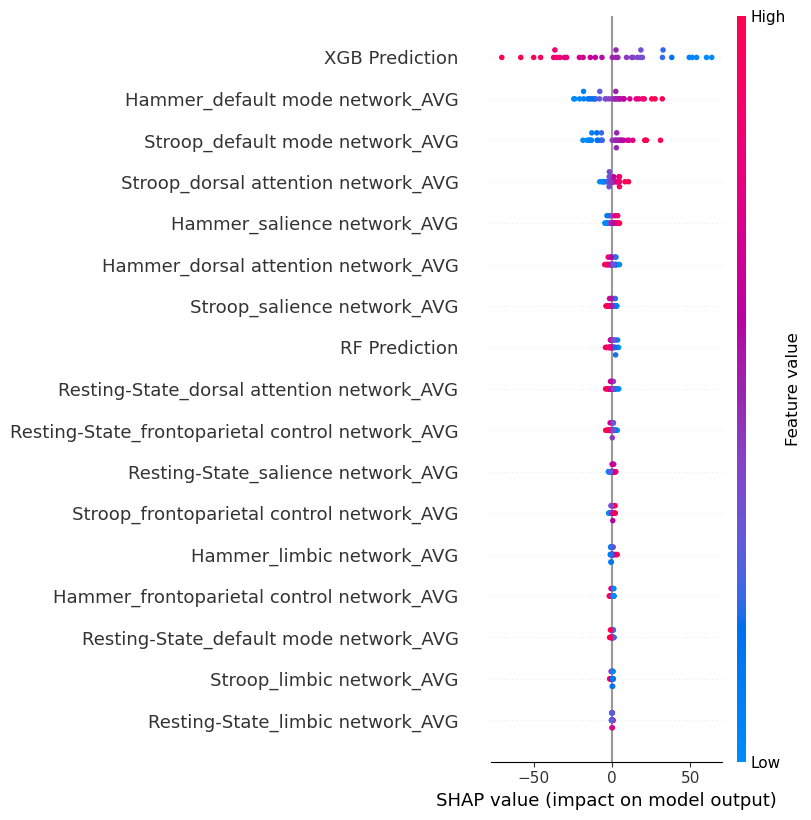

In [49]:
# Prepare the input data for the meta-model
xgb_preds = stacking_model.named_estimators_['xgb'].predict(X_test)
rf_preds = stacking_model.named_estimators_['rf'].predict(X_test)

# Combine original features with base model predictions
meta_input = np.column_stack((X_test, xgb_preds, rf_preds))

# Create feature names
feature_names = list(X_test.columns) + ['XGB Prediction', 'RF Prediction']

# Convert to a Pandas DataFrame for SHAP compatibility
meta_input_df = pd.DataFrame(meta_input, columns=feature_names)

# Use SHAP to explain the meta-model
explainer = shap.Explainer(stacking_model.final_estimator_, meta_input_df)
shap_values = explainer(meta_input_df)

# Plot the summary plot with feature names
shap.summary_plot(shap_values, meta_input_df)


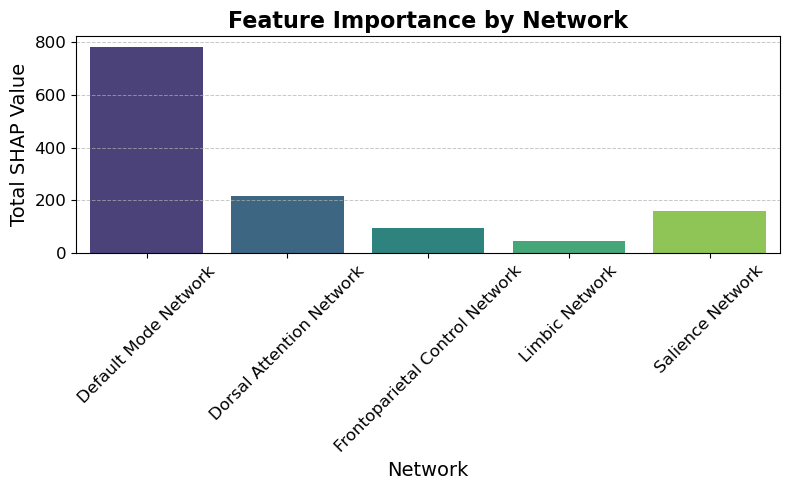

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Group features by network and task
network_groups = {
    'Default Mode Network': [col for col in meta_input_df.columns if 'default mode network' in col],
    'Dorsal Attention Network': [col for col in meta_input_df.columns if 'dorsal attention network' in col],
    'Frontoparietal Control Network': [col for col in meta_input_df.columns if 'frontoparietal control network' in col],
    'Limbic Network': [col for col in meta_input_df.columns if 'limbic network' in col],
    'Salience Network': [col for col in meta_input_df.columns if 'salience network' in col]
}

task_groups = {
    'Resting State': [col for col in meta_input_df.columns if 'Resting-State' in col],
    'Hammer': [col for col in meta_input_df.columns if 'Hammer' in col],
    'Stroop': [col for col in meta_input_df.columns if 'Stroop' in col]
}

# Convert shap_values to a numpy array
shap_values_array = shap_values.values  # Extract SHAP values

# Calculate feature importance per group
network_importance = {network: sum(np.abs(shap_values_array[:, meta_input_df.columns.get_loc(col)]).sum() for col in cols)
                      for network, cols in network_groups.items()}

task_importance = {task: sum(np.abs(shap_values_array[:, meta_input_df.columns.get_loc(col)]).sum() for col in cols)
                   for task, cols in task_groups.items()}

# Plot feature importance per network
plt.figure(figsize=(8, 5))
sns.barplot(x=list(network_importance.keys()), y=list(network_importance.values()), palette="viridis")
plt.title('Feature Importance by Network', fontsize=16, weight='bold')
plt.xlabel('Network', fontsize=14)
plt.ylabel('Total SHAP Value', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()


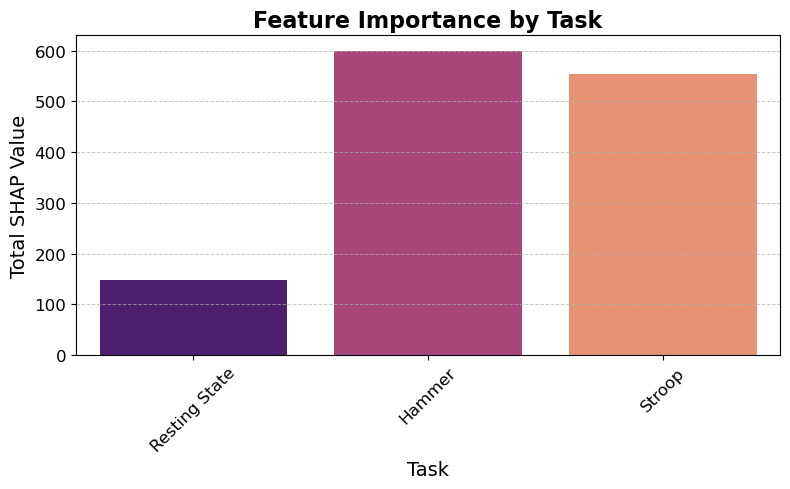

In [51]:
# Plot feature importance per task
plt.figure(figsize=(8, 5))
sns.barplot(x=list(task_importance.keys()), y=list(task_importance.values()), palette="magma")
plt.title('Feature Importance by Task', fontsize=16, weight='bold')
plt.xlabel('Task', fontsize=14)
plt.ylabel('Total SHAP Value', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.tight_layout()

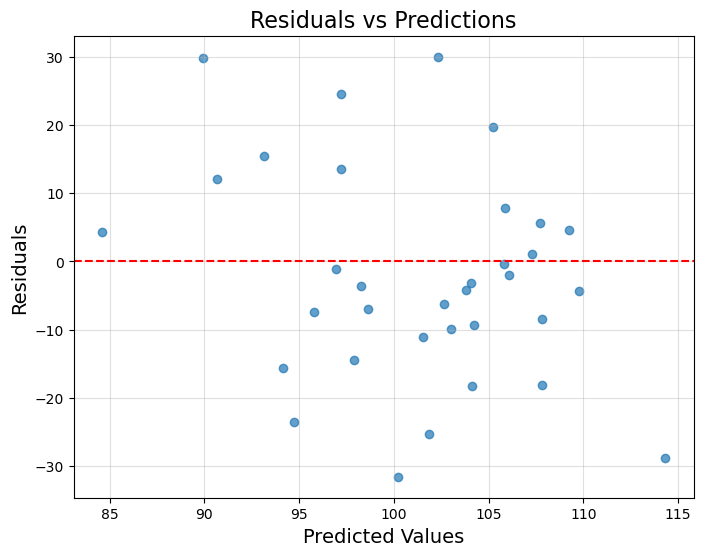

In [52]:
# Residuals plot
import matplotlib.pyplot as plt

residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1.5)
plt.title('Residuals vs Predictions', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.grid(alpha=0.4)
plt.show()


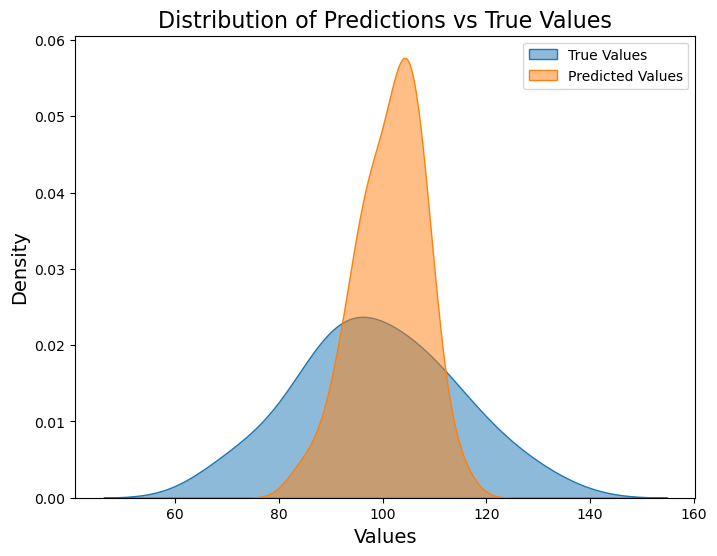

In [53]:
# Distribution of predictions vs true values
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.kdeplot(y_test, label='True Values', fill=True, alpha=0.5)
sns.kdeplot(y_pred, label='Predicted Values', fill=True, alpha=0.5)
plt.title('Distribution of Predictions vs True Values', fontsize=16)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.legend()
plt.show()


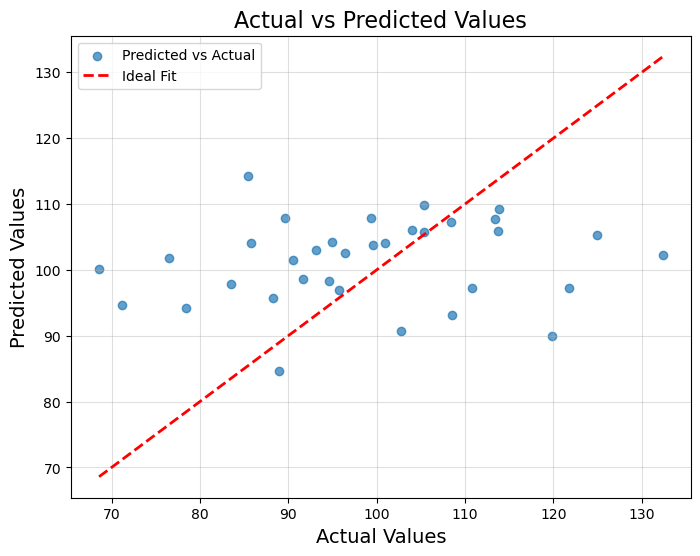

In [54]:
# Actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal Fit')
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.legend()
plt.grid(alpha=0.4)
plt.show()


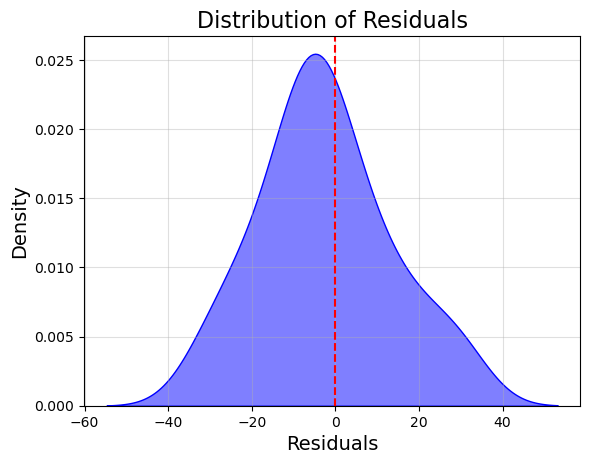

In [55]:
# Distribution of residuals
sns.kdeplot(residuals, fill=True, color="blue", alpha=0.5)
plt.title('Distribution of Residuals', fontsize=16)
plt.xlabel('Residuals', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.axvline(0, color='red', linestyle='--', linewidth=1.5)
plt.grid(alpha=0.4)
plt.show()


In [56]:
# Baseline model training and evaluation

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

# Train baseline models with optimal hyperparameters
xgb_baseline = XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=50, random_state=42)
rf_baseline = RandomForestRegressor(max_depth=5, min_samples_split=2, n_estimators=50, random_state=42)

# Train the stacking ensemble model
meta_model = GradientBoostingRegressor(n_estimators=50, random_state=42)
stacking_model = StackingRegressor(
    estimators=[('xgb', xgb_baseline), ('rf', rf_baseline)],
    final_estimator=meta_model,
    passthrough=False  # Remove passthrough, which excludes the original features from the meta-model
)
stacking_model.fit(X_train, y_train)

# Fit all models on the training set
stacking_model.fit(X_train, y_train)

# Test all models on X_test
# XGBoost Predictions
xgb_baseline.fit(X_train, y_train)
xgb_pred = xgb_baseline.predict(X_test)

# Random Forest Predictions
rf_baseline.fit(X_train, y_train)
rf_pred = rf_baseline.predict(X_test)

# Stacking Ensemble Predictions
ensemble_pred = stacking_model.predict(X_test)

# Calculate MAE for each model
xgb_mae_baseline = mean_absolute_error(y_test, xgb_pred)
rf_mae_baseline = mean_absolute_error(y_test, rf_pred)
ensemble_mae_baseline = mean_absolute_error(y_test, ensemble_pred)

# Print results
print(f"XGBoost Baseline Test MAE: {xgb_mae_baseline:.3f}")
print(f"Random Forest Baseline Test MAE: {rf_mae_baseline:.3f}")
print(f"Ensemble (Stacking) Baseline Test MAE: {ensemble_mae_baseline:.3f}")


XGBoost Baseline Test MAE: 13.030
Random Forest Baseline Test MAE: 12.187
Ensemble (Stacking) Baseline Test MAE: 11.663


In [57]:
# Data
models = ['XGBoost', 'Random Forest', 'Ensemble']
mae_values = [xgb_mae_baseline, rf_mae_baseline, ensemble_mae_baseline]

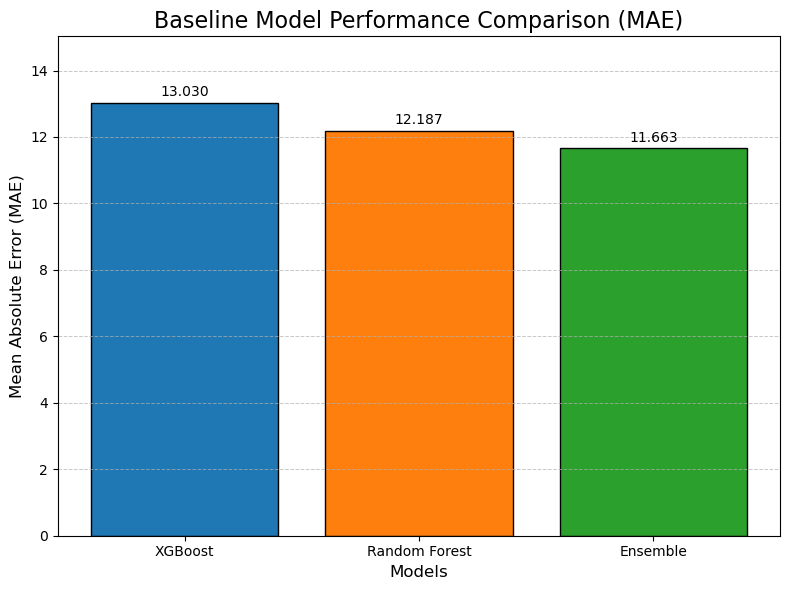

In [58]:
# Baseline model performance comparison
plt.figure(figsize=(8, 6))
plt.bar(models, mae_values, color=['#1f77b4', '#ff7f0e', '#2ca02c'], edgecolor='black')
plt.title('Baseline Model Performance Comparison (MAE)', fontsize=16)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.xlabel('Models', fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
plt.ylim(0, max(mae_values) + 2)
for i, v in enumerate(mae_values):
    plt.text(i, v + 0.2, f'{v:.3f}', ha='center', fontsize=10)
plt.tight_layout()
plt.show()

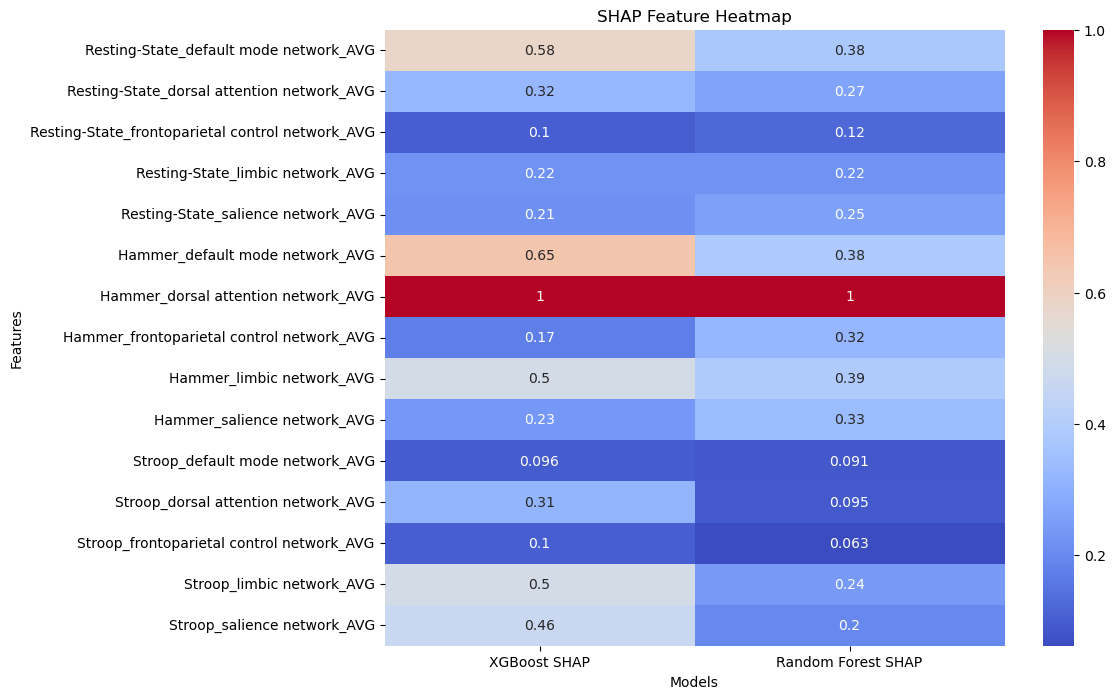

In [59]:
# SHAP feature heatmap 

# Compute SHAP values for both models
xgb_explainer = shap.Explainer(xgb_baseline, X_train)
xgb_shap_values = xgb_explainer(X_test)
rf_explainer = shap.Explainer(rf_baseline, X_train)
rf_shap_values = rf_explainer(X_test)

# Aggregate mean absolute SHAP values for comparison
xgb_mean_shap = pd.DataFrame({
    'Feature': X_train.columns,
    'XGBoost SHAP': abs(xgb_shap_values.values).mean(axis=0)
})
rf_mean_shap = pd.DataFrame({
    'Feature': X_train.columns,
    'Random Forest SHAP': abs(rf_shap_values.values).mean(axis=0)
})

# Merge and normalize for heatmap
shap_importance = pd.merge(xgb_mean_shap, rf_mean_shap, on='Feature').set_index('Feature')
normalized_importance = shap_importance / shap_importance.max()

# Plot SHAP heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_importance, annot=True, cmap='coolwarm', cbar=True)
plt.title('SHAP Feature Heatmap')
plt.ylabel('Features')
plt.xlabel('Models')
plt.show()


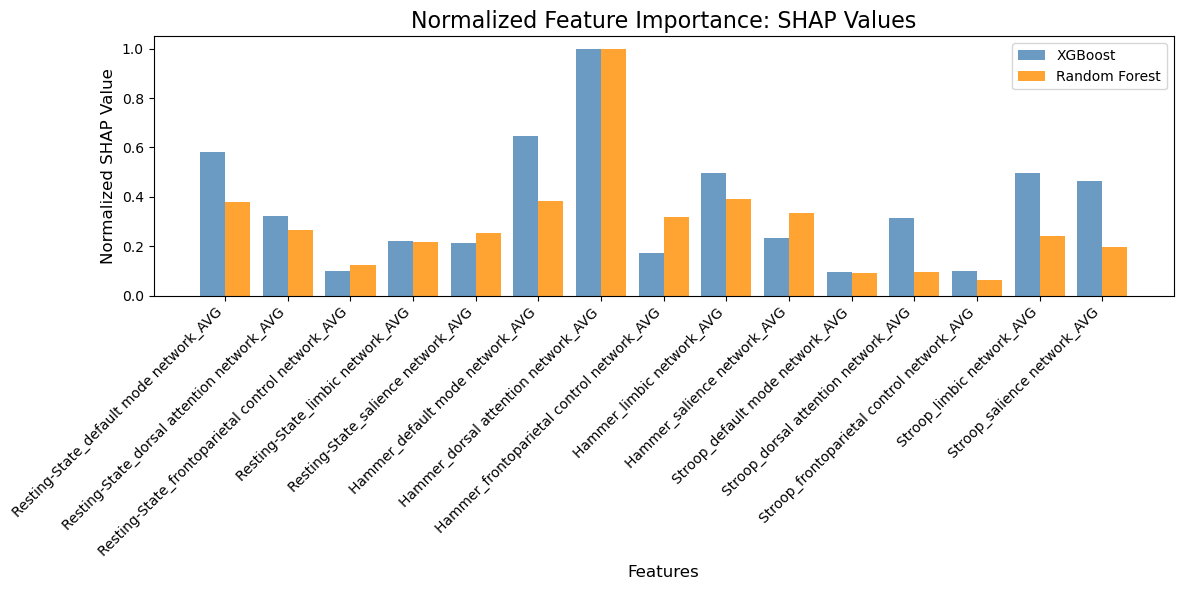

In [60]:
# Feature importance bar charts

import matplotlib.pyplot as plt
import numpy as np

# Plot normalized SHAP values
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(normalized_importance.index))
bar_width = 0.4

# Plot XGBoost bars
ax.bar(x - bar_width / 2, normalized_importance['XGBoost SHAP'], 
       width=bar_width, label='XGBoost', color='steelblue', alpha=0.8)

# Plot Random Forest bars
ax.bar(x + bar_width / 2, normalized_importance['Random Forest SHAP'], 
       width=bar_width, label='Random Forest', color='darkorange', alpha=0.8)

# Add labels, title, and legend
ax.set_title('Normalized Feature Importance: SHAP Values', fontsize=16)
ax.set_ylabel('Normalized SHAP Value', fontsize=12)
ax.set_xlabel('Features', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(normalized_importance.index, rotation=45, ha='right', fontsize=10)
ax.legend(fontsize=10)

# Adjust layout
plt.tight_layout()
plt.show()


Feature Importance for XGBoost:


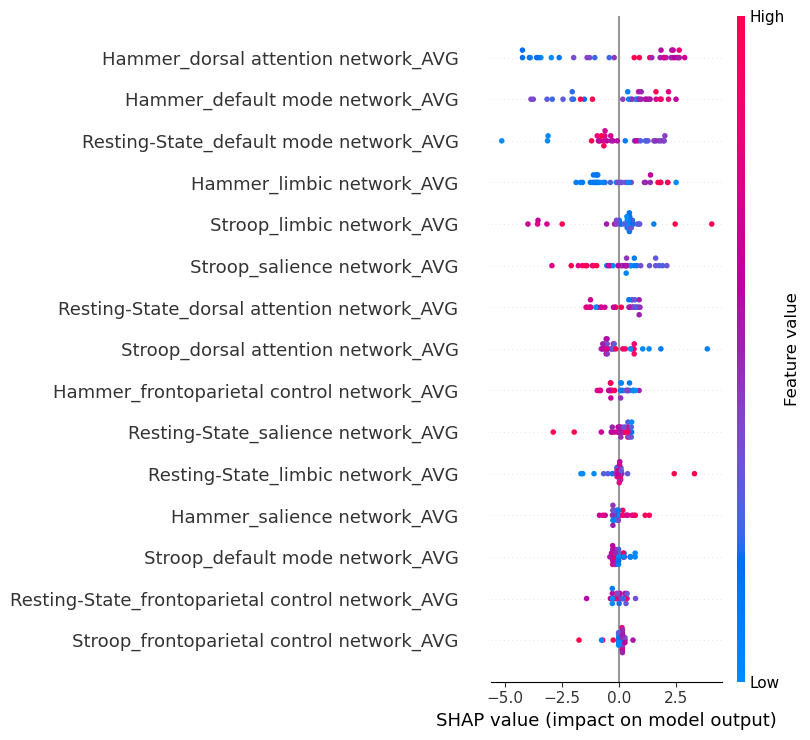

Feature Importance for Random Forest:


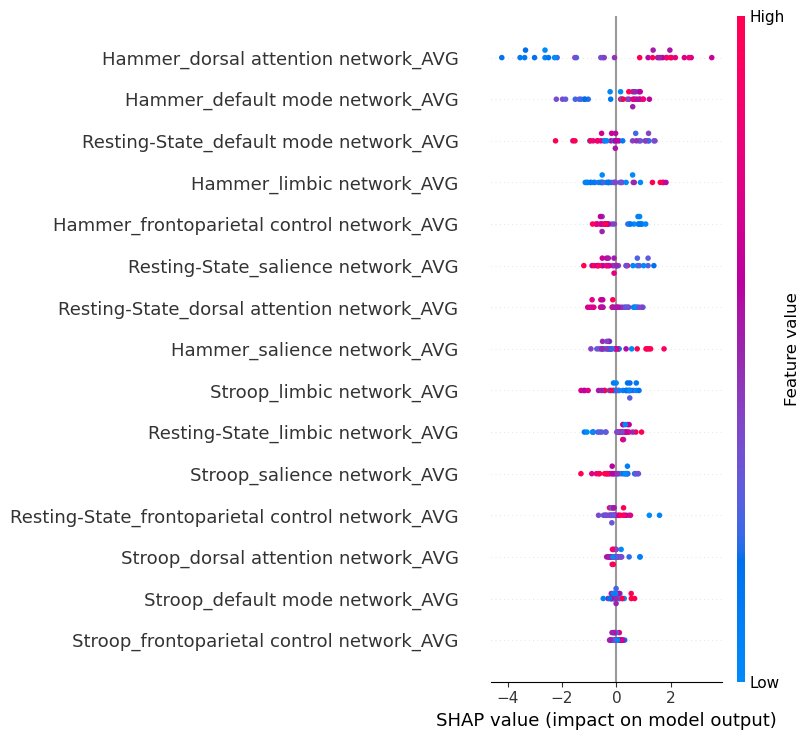

In [61]:
# Feature importance plot for single predictions

import shap

# Explain the XGBoost base model
xgb_explainer = shap.Explainer(stacking_model.named_estimators_['xgb'], X_test)
xgb_shap_values = xgb_explainer(X_test)

# Plot feature importance for XGBoost
print("Feature Importance for XGBoost:")
shap.summary_plot(xgb_shap_values, X_test)

# Explain the Random Forest base model
rf_explainer = shap.Explainer(stacking_model.named_estimators_['rf'], X_test)
rf_shap_values = rf_explainer(X_test)

# Plot feature importance for Random Forest
print("Feature Importance for Random Forest:")
shap.summary_plot(rf_shap_values, X_test)


X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without feature names
X has feature names, but GradientBoostingRegressor was fitted without featur

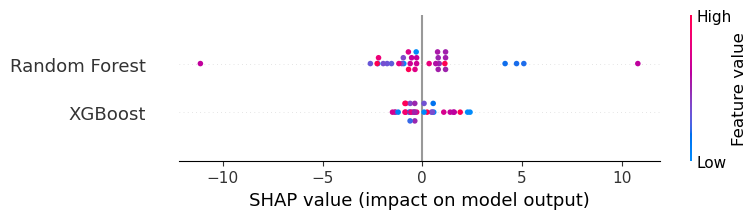

In [62]:
# Meta-model model importance in single predictions

import shap
import numpy as np

# Prepare data for SHAP explanation
meta_input = np.column_stack((
    xgb_pred,  # XGBoost predictions
    rf_pred    # Random Forest predictions
))

# Create a DataFrame for SHAP explanation
meta_input_df = pd.DataFrame(meta_input, columns=['XGBoost', 'Random Forest'])

# Use SHAP's PermutationExplainer for the ensemble model (meta-model)
meta_explainer = shap.PermutationExplainer(stacking_model.final_estimator_.predict, meta_input_df)
meta_shap_values = meta_explainer.shap_values(meta_input_df)

# Plot SHAP summary for the ensemble meta-model
shap.summary_plot(meta_shap_values, meta_input_df)


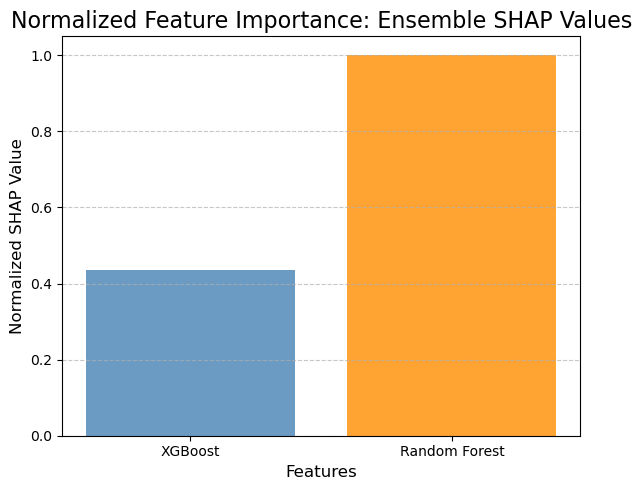

In [63]:
# Ensemble SHAP values

import pandas as pd
import matplotlib.pyplot as plt

# Aggregate SHAP values from previous code block for global importance
meta_mean_shap = pd.DataFrame({
    'Feature': meta_input_df.columns, 
    'Meta-Model SHAP': abs(meta_shap_values).mean(axis=0)  # Aggregate SHAP values across all samples
})

# Normalize SHAP values for consistency
meta_mean_shap['Normalized SHAP'] = meta_mean_shap['Meta-Model SHAP'] / meta_mean_shap['Meta-Model SHAP'].max()

# Plot normalized SHAP values
plt.figure(figsize=(6, 5))
colors = ['steelblue', 'darkorange']

# Create the bar chart
plt.bar(meta_mean_shap['Feature'], meta_mean_shap['Normalized SHAP'], color=colors, alpha=0.8, width=0.8)

# Add labels and titles
plt.title('Normalized Feature Importance: Ensemble SHAP Values', fontsize=16)
plt.ylabel('Normalized SHAP Value', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [64]:
import pandas as pd

# Prepare the results dictionary for MAE
mae_results = {
    'XGBoost': [xgb_mae_baseline],
    'Random Forest': [rf_mae_baseline],
    'Ensemble': [ensemble_mae_baseline]
}
mae_results_df = pd.DataFrame(mae_results, index=['Baseline MAE'])  # Baseline MAE row name remains as is

# Assign meaningful row names for feature SHAP importance, ensuring 'SHAP' is added only once
normalized_importance.index = [f"{feature} SHAP" for feature in normalized_importance.index]

# Create a DataFrame for model SHAP importance with proper row names
meta_model_importance_df = pd.DataFrame({
    'Normalized SHAP': meta_mean_shap['Normalized SHAP']
})
meta_model_importance_df.index = [f"{model} SHAP" for model in meta_mean_shap.index]

# Combine all results into a single DataFrame
results_combined = pd.concat(
    [
        mae_results_df,  # Baseline MAE
        normalized_importance,  # Feature SHAP importance
        meta_model_importance_df  # Model SHAP importance
    ]
)

# Save the results to a CSV file
results_combined.to_csv('baseline_results.csv', index_label='Row Name')
print("Baseline results saved to 'baseline_results.csv' with properly formatted row names.")


Baseline results saved to 'baseline_results.csv' with properly formatted row names.


In [65]:
# Load the CSV file
file_path = 'baseline_results.csv'

# Read the CSV file into a DataFrame
results_combined = pd.read_csv(file_path, index_col=0)  # Index column is important for row names

# Display the first few rows of the entire file
print("Baseline Results (Full CSV):")
print(results_combined.head(), "\n")

# Check if sections are correctly separated
print("Baseline MAE Section:")
print(results_combined.loc['Baseline MAE'], "\n")  # Check MAE section

print("Feature SHAP Importance Section (Example Features):")
feature_rows = [index for index in results_combined.index if 'Feature SHAP' in index]
print(results_combined.loc[feature_rows].head(), "\n")  # Check feature SHAP values

print("Model SHAP Importance Section:")
model_rows = [index for index in results_combined.index if 'Model SHAP' in index]
print(results_combined.loc[model_rows], "\n")  # Check model SHAP importance

# Validate structure of the file
print("Columns in the File:")
print(results_combined.columns)

print("Index Levels in the File:")
print(results_combined.index.unique())


Baseline Results (Full CSV):
                                                      XGBoost  Random Forest  \
Row Name                                                                       
Baseline MAE                                        13.029545      12.186859   
Resting-State_default mode network_AVG SHAP               NaN            NaN   
Resting-State_dorsal attention network_AVG SHAP           NaN            NaN   
Resting-State_frontoparietal control network_AV...        NaN            NaN   
Resting-State_limbic network_AVG SHAP                     NaN            NaN   

                                                     Ensemble  XGBoost SHAP  \
Row Name                                                                      
Baseline MAE                                        11.663129           NaN   
Resting-State_default mode network_AVG SHAP               NaN      0.582189   
Resting-State_dorsal attention network_AVG SHAP           NaN      0.323890   
Resting-State_f

In [66]:
import os
import pandas as pd

# Create the folder 'baseline_results' if it doesn't exist
os.makedirs('baseline_results', exist_ok=True)

# Prepare the results dictionary for MAE
mae_results = {
    'Model': ['XGBoost', 'Random Forest', 'Ensemble'],
    'Baseline MAE': [xgb_mae_baseline, rf_mae_baseline, ensemble_mae_baseline]
}

# Create and save the MAE DataFrame
mae_results_df = pd.DataFrame(mae_results)
mae_results_df.to_csv('baseline_results/baseline_mae.csv', index=False)

print("Saved 'baseline_mae.csv' to 'baseline_results' folder.")


Saved 'baseline_mae.csv' to 'baseline_results' folder.


In [75]:
# Ensure `normalized_importance` has meaningful index and columns
if normalized_importance.index.name != 'Feature':
    normalized_importance.reset_index(inplace=True)
    normalized_importance.rename(columns={'index': 'Feature'}, inplace=True)

# Remove any column named 'Normalized SHAP' if it exists
if 'Normalized SHAP' in normalized_importance.columns:
    normalized_importance.drop(columns=['Normalized SHAP'], inplace=True)

# Save normalized importance to CSV
normalized_importance.to_csv('baseline_results/baseline_feature_shap.csv', index=False)
print("Saved 'baseline_feature_shap.csv' without an unnecessary 'Normalized SHAP' column.")


Saved 'baseline_feature_shap.csv' without an unnecessary 'Normalized SHAP' column.


In [77]:
# Prepare model SHAP importance
meta_model_importance_df = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest'],  # Explicitly name rows
    'Normalized SHAP': meta_mean_shap['Normalized SHAP'].values  # Use SHAP values
})

# Save the model SHAP importance to a CSV file
meta_model_importance_df.to_csv('baseline_results/baseline_model_shap.csv', index=False)

print("Saved 'baseline_model_shap.csv' to 'baseline_results' folder with correctly named rows.")


Saved 'baseline_model_shap.csv' to 'baseline_results' folder with correctly named rows.


In [78]:
import pandas as pd
import os

# Define the folder path
folder_path = 'baseline_results'

# Check if the folder and files exist
if os.path.exists(folder_path):
    # Check and load each file
    print("Checking baseline results folder...\n")
    
    # Load baseline MAE file
    mae_file = os.path.join(folder_path, 'baseline_mae.csv')
    if os.path.exists(mae_file):
        mae_results_df = pd.read_csv(mae_file)
        print("Baseline MAE:")
        print(mae_results_df.head(), "\n")
    else:
        print("File 'baseline_mae.csv' not found.\n")
    
    # Load baseline feature SHAP file
    feature_shap_file = os.path.join(folder_path, 'baseline_feature_shap.csv')
    if os.path.exists(feature_shap_file):
        feature_shap_df = pd.read_csv(feature_shap_file)
        print("Baseline Feature SHAP Importance:")
        print(feature_shap_df.head(), "\n")
    else:
        print("File 'baseline_feature_shap.csv' not found.\n")
    
    # Load baseline model SHAP file
    model_shap_file = os.path.join(folder_path, 'baseline_model_shap.csv')
    if os.path.exists(model_shap_file):
        model_shap_df = pd.read_csv(model_shap_file)
        print("Baseline Model SHAP Importance:")
        print(model_shap_df.head(), "\n")
    else:
        print("File 'baseline_model_shap.csv' not found.\n")
else:
    print("Folder 'baseline_results' does not exist. Please ensure the files were saved correctly.")



Checking baseline results folder...

Baseline MAE:
           Model  Baseline MAE
0        XGBoost     13.029545
1  Random Forest     12.186859
2       Ensemble     11.663129 

Baseline Feature SHAP Importance:
   Feature  Feature.1                                          Feature.2  \
0        0          0        Resting-State_default mode network_AVG SHAP   
1        1          1    Resting-State_dorsal attention network_AVG SHAP   
2        2          2  Resting-State_frontoparietal control network_A...   
3        3          3              Resting-State_limbic network_AVG SHAP   
4        4          4            Resting-State_salience network_AVG SHAP   

   XGBoost SHAP  Random Forest SHAP  
0      0.582189            0.380300  
1      0.323890            0.266062  
2      0.099785            0.124026  
3      0.219754            0.216386  
4      0.212891            0.253841   

Baseline Model SHAP Importance:
           Model  Normalized SHAP
0        XGBoost         0.436606
1 